# Imports

In [1]:
# Qsurface imports
from qsurface.main import create_phenomenological_toric_superoperator, create_phenomenological_weight_3_toric_superoperator,create_phenomenological_weight_4_toric_superoperator, initialize, run, BenchmarkDecoder, run_multiprocess_superoperator


# Interactive plotting imports
from bokeh.plotting import figure, show
from bokeh.models import Label
from bokeh.util.compiler import TypeScript

# Plotting imports
import matplotlib.pyplot as plt

# Math imports
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import math

# Utilities import
from os import listdir
from os.path import isfile, join
from itertools import permutations
import timeit
import time


%load_ext line_profiler

# CSVs Correction

In [ ]:
''' This block creates a separate dataframe and fills it up with the new combination of error string and uses
the rest same values. And merges them later with a resetted index.'''
files = [f for f in listdir("C:/qarch/qsurface/data/monolithic") if isfile(join("C:/qarch/qsurface/data/monolithic", f))]
new_location = ["C:/qarch/qsurface/data/monolithic/normalized/"+ f for f in files]
FILES = ["C:/qarch/qsurface/data/monolithic/"+ f for f in files]

for new_loc, location in zip(new_location, FILES):
    data = pd.read_csv(location, sep=';')

    data2 = pd.DataFrame(columns=data.columns)
    for index, row in data.iterrows():
        perms = [''.join(p) for p in set(permutations(row["error_config"]))]
        for permutation in perms:
            if permutation == row["error_config"]:
                continue
            else:
                data2.loc[data2.shape[0]] = [permutation, row['lie'], row['p'], row['s'],0,0,0,0,0,0,0,0,0,0,0,0,0]

    data_merged = pd.concat([data, data2]).reset_index()
    del data_merged['index']

    '''Now we need to rescale the error permutation star and plaquette weights. And later normalize the whole superoperator.'''
    # Finding the right weights

    for index, row in data.iterrows():
        perms = [''.join(p) for p in set(permutations(row["error_config"]))]
        n_perms = len(perms)

        for index_f, row_f in data_merged.iterrows():
            if row_f['error_config'] in perms and row_f['lie'] == row['lie']:
                data_merged.loc[index_f,'p'] = row_f['p']/n_perms
                data_merged.loc[index_f,'s'] = row_f['s']/n_perms

    # Normalizing the whole CSV weights

    psum = data_merged['p'].sum()
    ssum = data_merged['s'].sum()

    data_merged['p'] = data_merged['p'].div(psum)
    data_merged['s'] = data_merged['s'].div(ssum)

    data_merged.to_csv(new_loc, sep=';', index=False)

# Create phenomenological superoperators

In [3]:
# error_rates = [float(round(x,3)) for x in np.linspace(0.0, 0.035, 20)]
# print(error_rates)
error_rates = [0.03]
for rate in error_rates:
    # index = time.strftime("%Y%m%d_%H%M%S")
    # create_phenomenological_weight_4_toric_superoperator(0.98,[rate, rate, rate, rate])
    create_phenomenological_weight_3_toric_superoperator(0.98,[rate, rate, rate, rate, rate, rate])
    # create_phenomenological_toric_superoperator([rate, rate, rate, rate])


In [2]:
rate = 0.03
create_phenomenological_toric_superoperator([rate, rate, rate, rate])
# create_phenomenological_weight_3_toric_superoperator(1,[rate, rate, rate, rate, rate, rate])
create_phenomenological_weight_4_toric_superoperator(1,[rate, rate, rate, rate])

# Time Scaling of Implementation

## Superoperator Mechanism

In [ ]:
file_location = "./data/weight_3_phenomenological/"
export_location = './data/weight_3_phenomenological/exported_data/time_scaling_weight3.json'
iters = 100


SIZE = [(4,4), (6,6), (8,8), (10,10), (12,12), (14,14), (16,16)]
files = [f for f in listdir(file_location) if isfile(join(file_location, f))]
FILES = [file_location + f for f in files]
N_RATE = len(FILES)

time_comp = {}
for serial in range(N_RATE):
    time_comp[serial] = []


for super, serial in zip(FILES, range(N_RATE)):
    for size in SIZE:
        start = timeit.default_timer()
        code, decoder = initialize(size, "weight_3_toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file=super, initial_states=(0,0))
        run(code, decoder, iterations=iters, decode_initial=False)
        stop = timeit.default_timer()
        duration = stop - start

        time_comp[serial].append(duration/iters)

print(time_comp)
export_data = pd.DataFrame(time_comp)

export_data.to_json(export_location)

## Original phenomenological implementation

In [ ]:
export_location = './data/exported_data/time_scaling.json'
iters = 1000


SIZE = [(4,4), (6,6), (8,8), (10,10), (12,12), (14,14), (16,16)]
ERRORS = [{"p_bitflip": 0.005, "p_phaseflip": 0.005, "p_bitflip_plaq": 0.005, "p_bitflip_star": 0.005},
{"p_bitflip": 0.01, "p_phaseflip": 0.01, "p_bitflip_plaq": 0.01, "p_bitflip_star": 0.01},
{"p_bitflip": 0.015, "p_phaseflip": 0.015, "p_bitflip_plaq": 0.015, "p_bitflip_star": 0.015},
{"p_bitflip": 0.02, "p_phaseflip": 0.02, "p_bitflip_plaq": 0.02, "p_bitflip_star": 0.02},
{"p_bitflip": 0.025, "p_phaseflip": 0.025, "p_bitflip_plaq": 0.025, "p_bitflip_star": 0.025},
{"p_bitflip": 0.03, "p_phaseflip": 0.03, "p_bitflip_plaq": 0.03, "p_bitflip_star": 0.03},
{"p_bitflip": 0.035, "p_phaseflip": 0.035, "p_bitflip_plaq": 0.035, "p_bitflip_star": 0.035},
{"p_bitflip": 0.04, "p_phaseflip": 0.04, "p_bitflip_plaq": 0.04, "p_bitflip_star": 0.04}
]
N_RATE = len(ERRORS)

time_comp = {}
for serial in range(N_RATE):
    time_comp[serial] = []


for error, serial in zip(ERRORS, range(N_RATE)):
    for size in SIZE:
        start = timeit.default_timer()
        code, decoder = initialize(size, "toric", "unionfind", enabled_errors=["pauli"],faulty_measurements=True, initial_states=(0,0))
        run(code, decoder, iterations=iters, error_rates=error, decode_initial=False)
        stop = timeit.default_timer()
        duration = stop - start

        time_comp[serial].append(duration/iters)

print(time_comp)
export_data = pd.DataFrame(time_comp)

export_data.to_json(export_location)

# Different Architecture Comparisons for phenomenological noise

## Monolithic comparison Phenomeological: Inbuilt vs Superoperator

### Superoperator

In [2]:
create_phenomenological_toric_superoperator([0.03,0.03,0.03,0.03])

In [5]:
code, decoder = initialize((4,4), "toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file="phenomenological_0.03_0.03_0.03_0.03_toric.csv", initial_states=(0,0))
benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})
print(run(code, decoder, iterations=1000, decode_initial=False, benchmark=benchmarker))

# %lprun -f code.init_superoperator_errors run(code, decoder, iterations=4, decode_initial=False)

Running iteration 1000/1000
{'no_error': 754, 'benchmark': {'decoded': 999, 'iterations': 1000, 'seed': 749.6737757, 'duration/decode/mean': 0.0014002708999995548, 'duration/decode/std': 0.0011852075302904617, 'count_calls/correct_edge/mean': 7.47047047047047, 'count_calls/correct_edge/std': 2.6563009644414493}}


### Perfect Measurements Plot default qsurface (i.i.d. Z)

In [52]:

Z_error_rate = [0.03, 0.04, 0.06, 0.08, 0.09, 0.10, 0.105, 0.11, 0.12, 0.13]
superoperator_Z_error_rate = [0.00767491, 0.0103148, 0.0157265, 0.021326, 0.0242011, 0.0271292, 0.0286139, 0.0301128, 0.0331543, 0.0362564]

X_error_rate = [0.03, 0.04, 0.06, 0.08, 0.09, 0.10, 0.105, 0.11, 0.12, 0.13]
superoperator_X_error_rate = [0.00767491, 0.0103148, 0.0157265, 0.021326, 0.0242011, 0.0271292, 0.0286139, 0.0301128, 0.0331543, 0.0362564]

fig = figure(title="Threshold for phenomenological i.i.d. Z errors (30k iterations, UnionFind)", x_axis_label="error probability", y_axis_label="successful decoding rate")
l6 = [0.972, 0.9651333333333333, 0.9204333333333333, 0.8329666666666666, 0.7802666666666667, 0.7151666666666666, 0.6911666666666667, 0.6646, 0.6042666666666666, 0.5486666666666666]
l8 = [0.9984666666666666, 0.9918333333333333, 0.9562333333333334, 0.8632, 0.7992666666666667, 0.7240666666666666, 0.6883666666666667, 0.6488666666666667, 0.5745333333333333, 0.5149333333333334]
l10 = [0.9995, 0.9967, 0.9717666666666667, 0.8831333333333333, 0.8141333333333334, 0.7293333333333333, 0.6875666666666667, 0.6377, 0.5548333333333333, 0.4791]
l12 = [0.9999, 0.9987333333333334, 0.9797, 0.8982, 0.8194666666666667, 0.7273333333333334, 0.6774333333333333, 0.6279666666666667, 0.5353, 0.45286666666666664]

fig.legend.title = "Lattice Size"
fig.legend.location = "top_right"


fig.line(Z_error_rate, l6, legend_label="6 X 6", color="green", line_width=2)
fig.line(Z_error_rate, l8, legend_label="8 X 8", color="navy", line_width=2)
fig.line(Z_error_rate, l10, legend_label="10 X 10", color="red", line_width=2)
fig.line(Z_error_rate, l12, legend_label="12 X 12", color="black", line_width=2)

fig.circle(Z_error_rate, l6, fill_color="green", size=5)
fig.circle(Z_error_rate, l8, fill_color="navy", size=5)
fig.circle(Z_error_rate, l10, fill_color="red", size=5)
fig.circle(Z_error_rate, l12, fill_color="black", size=5)

show(fig)

c:\qarch\qs_env\lib\site-packages\bokeh\models\plots.py:815: UserWarning: 
You are attempting to set `plot.legend.title` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
c:\qarch\qs_env\lib\site-packages\bokeh\models\plots.py:815: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


### Faulty Measurements phenomenological (original)

In [53]:
p = [0.024, 0.026, 0.028, 0.029, 0.030, 0.032]

fig = figure(title="Threshold for toric faulty measurements (10k iterations, UnionFind)", x_axis_label="error probability p", y_axis_label="successful decoding rate")

l6 = [0.8962, 0.8556, 0.8026, 0.7817, 0.7485, 0.6973]
l8 = [0.9185, 0.8665, 0.8086, 0.7802, 0.7394, 0.6556]
l10 = [0.9315, 0.8758, 0.8036, 0.7558, 0.7093, 0.6068]
l12 = [0.94, 0.879, 0.7953, 0.7448, 0.6738, 0.5419]

fig.line(p, l6, legend_label="6 X 6", color="green", line_width=2)
fig.line(p, l8, legend_label="8 X 8", color="navy", line_width=2)
fig.line(p, l10, legend_label="10 X 10", color="red", line_width=2)
fig.line(p, l12, legend_label="12 X 12", color="black", line_width=2)

fig.circle(p, l6, fill_color="green", size=5)
fig.circle(p, l8, fill_color="navy", size=5)
fig.circle(p, l10, fill_color="red", size=5)
fig.circle(p, l12, fill_color="black", size=5)

show(fig)

c:\qarch\qs_env\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


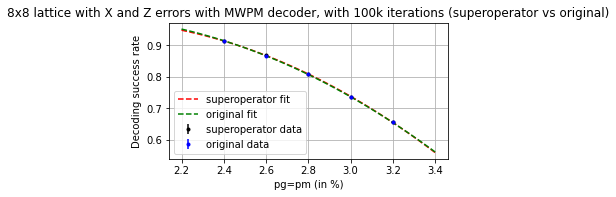

In [55]:


# 100k iterations union find, sweeping over error rates, 8X8 lattices
super8x8 = np.array([0.91377, 0.86901, 0.81006, 0.73659, 0.65606])
original8x8 = np.array([0.91455, 0.868, 0.80849, 0.73488, 0.6559])
rates = np.array([2.4, 2.6, 2.8, 3.0, 3.2])

def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

def err(x):
    return math.sqrt(x*(1-x)/9999)
error_super = [err(x) for x in super8x8]
error_original = [err(x) for x in original8x8]

rng = np.random.default_rng()
popt_super, pcov_super = curve_fit(fitting_function, rates, super8x8)
popt_original, pcov_original = curve_fit(fitting_function, rates, original8x8)

fig = plt.figure(figsize=(5,2.5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('8x8 lattice with X and Z errors with MWPM decoder, with 100k iterations (superoperator vs original)')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('pg=pm (in %)')
plt.grid()

plt.errorbar(rates,super8x8,yerr=error_super, fmt='k.')
plt.plot(np.linspace(2.2, 3.4, 100),fitting_function(np.linspace(2.2, 3.4, 100),popt_super[0],popt_super[1],popt_super[2],popt_super[3],popt_super[4]),'r--', label='superoperator')

plt.errorbar(rates,original8x8,yerr=error_original,fmt='b.')
plt.plot(np.linspace(2.2, 3.4, 100),fitting_function(np.linspace(2.2, 3.4, 100),popt_original[0],popt_original[1],popt_original[2],popt_original[3],popt_original[4]),'g--', label='original')
plt.legend(['superoperator fit','original fit','superoperator data','original data'])
plt.savefig('comparison.pdf')


In [32]:
{(4, 4): [0.84653], (5, 5): [0.93858], (6, 6): [0.9086], (7, 7): [0.95859], (8, 8): [0.93973]} # Original
{(4, 4): [0.84479], (5, 5): [0.93904], (6, 6): [0.90901], (7, 7): [0.95795], (8, 8): [0.93995]} # Super

In [3]:
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.005,0.005,0.005,0.005,0.005,0.005])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.01,0.01,0.01,0.01,0.01,0.01])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.015,0.015,0.015,0.015,0.015,0.015])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.02,0.02,0.02,0.02,0.02,0.02])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.025,0.025,0.025,0.025,0.025,0.025])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.03,0.03,0.03,0.03,0.03,0.03])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.035,0.035,0.035,0.035,0.035,0.035])
# create_phenomenological_weight_3_toric_superoperator(1,0.9, [0.04,0.04,0.04,0.04,0.04,0.04])
create_phenomenological_weight_3_toric_superoperator(1, [0.05,0.05,0.05,0.05,0.05,0.05])

ValueError: All arrays must be of the same length

## Weight-3 vs phenomenological

In [15]:
p_bitflip = 0.05
p_phaseflip = 0.05
p_bitflip_plaq = 0.05
p_bitflip_star = 0.05

benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})

code, decoder = initialize((4,4), "toric", "unionfind", enabled_errors=["pauli"], plotting=False, initial_states=(0,0), faulty_measurements=True)
print(run(code, decoder, iterations=2000, error_rates={"p_bitflip": p_bitflip, "p_phaseflip": p_phaseflip, "p_bitflip_plaq": p_bitflip_plaq, "p_bitflip_star": p_bitflip_star}, decode_initial=False, benchmark=benchmarker))
print(benchmarker.data)
# %lprun -f run run(code, decoder, iterations=10, decode_initial=False)

Running iteration 2000/2000
{'no_error': 796, 'benchmark': {'decoded': 2000, 'iterations': 2000, 'seed': 5811.743537, 'duration/decode/mean': 0.0016770700500019302, 'duration/decode/std': 0.0014941176013230164, 'count_calls/correct_edge/mean': 11.7955, 'count_calls/correct_edge/std': 3.157796660648054}}
{'decoded': 2000, 'iterations': 2000, 'seed': 5811.743537}


In [43]:
code, decoder = initialize((4,4), "weight_3_toric", "unionfind", plotting=False, superoperator_enable=True, sup_op_file="phenomenological_wt_3_toric_px_0.05_pz_0.05_prx_0.05_prz_0.05_pmx_0.05_pmz_0.05_ghz_1.csv", initial_states=(0,0))
benchmarker = BenchmarkDecoder({
        "decode": ["duration", "value_to_list"],
        "correct_edge": "count_calls",})
print(run(code, decoder, iterations=100, decode_initial=False, benchmark=benchmarker, seed=10))

Running iteration 100/100
{'no_error': 50, 'benchmark': {'decoded': 100, 'iterations': 100, 'seed': 100.0, 'duration/decode/mean': 0.0015184300001419614, 'duration/decode/std': 0.00048373419095903156, 'count_calls/correct_edge/mean': 11.96, 'count_calls/correct_edge/std': 2.9220540720527404}}


: 

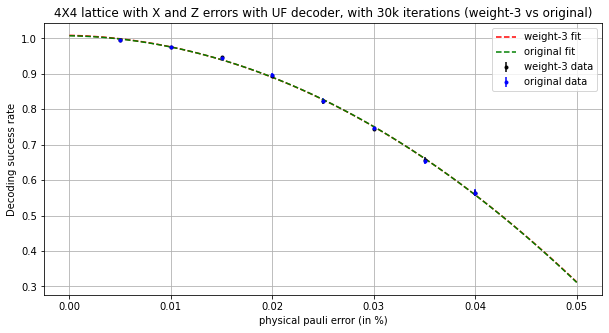

In [35]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

weight_3 = np.array([0.9945666667, 0.9770333333, 0.9465333333, 0.8950666667, 0.8226666667, 0.7457333333, 0.6566, 0.5643666667])

original = np.array([0.9946666666666667, 0.9762833333333333, 0.9440833333333334, 0.8974833333333333, 0.8236833333333333, 0.7462, 0.6551666666666667, 0.5647333333333333])
rates = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
iterations = 30000

def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/3000)
error_wt_3 = [err(x) for x in weight_3]
error_original = [err(x) for x in original]

rng = np.random.default_rng()
popt_super, pcov_super = curve_fit(fitting_function, rates, weight_3)
popt_original, pcov_original = curve_fit(fitting_function, rates, original)

fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('4X4 lattice with X and Z errors with UF decoder, with 30k iterations (weight-3 vs original)')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('physical pauli error (in %)')
plt.grid()

plt.errorbar(rates,weight_3,yerr=error_wt_3, fmt='k.')
plt.plot(np.linspace(0.0, 0.05, 100),fitting_function(np.linspace(0.0, 0.05, 100),popt_super[0],popt_super[1],popt_super[2],popt_super[3],popt_super[4]),'r--', label='superoperator')

plt.errorbar(rates,original,yerr=error_original,fmt='b.')
plt.plot(np.linspace(0.0, 0.05, 100),fitting_function(np.linspace(0.0, 0.05, 100),popt_original[0],popt_original[1],popt_original[2],popt_original[3],popt_original[4]),'g--', label='original')
plt.legend(['weight-3 fit','original fit','weight-3 data','original data'])
plt.savefig('comparison.pdf')


# Supercomputer data calculations for phenomenological noise verification

## Threshold for weight 0 phenomenological

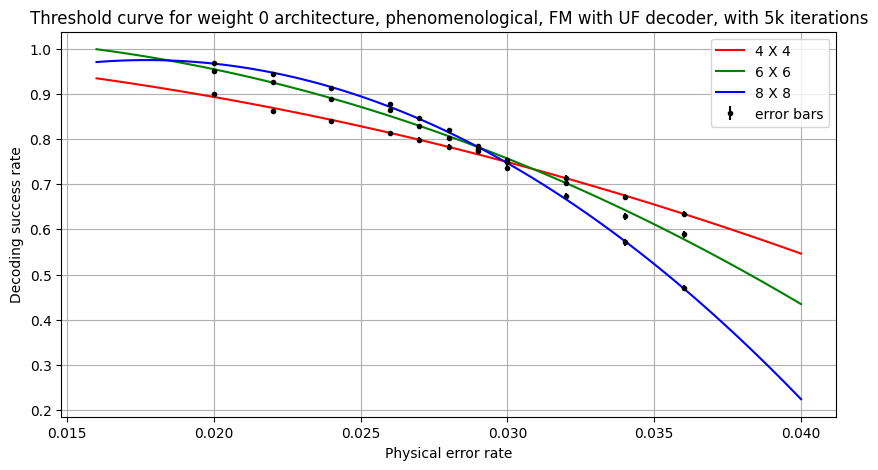

In [11]:
rates = np.array([0.020, 0.022, 0.024, 0.026, 0.027, 0.028, 0.029, 0.030, 0.032, 0.034, 0.036])
iterations = 5000

wt0_l4= np.array([4495,4314,4195,4065,3991,3913,3865,3751,3565,3357,3175])/iterations
wt0_l6= np.array([4752, 4636, 4447, 4319, 4143, 4008, 3920,3766, 3519, 3143, 2944])/iterations
wt0_l8 = np.array([4840, 4723, 4563, 4390, 4229, 4101, 3891,3682, 3365, 2855, 2353])/iterations

# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0_l4 = [err(x) for x in wt0_l4]
error_wt0_l6 = [err(x) for x in wt0_l6]
error_wt0_l8 = [err(x) for x in wt0_l8]

rng = np.random.default_rng()

popt_wt0_l4, pcov_wt0_l4 = curve_fit(fitting_function, rates, wt0_l4, maxfev = 5000)
popt_wt0_l6, pcov_wt0_l6 = curve_fit(fitting_function, rates, wt0_l6, maxfev = 5000)
popt_wt0_l8, pcov_wt0_l8 = curve_fit(fitting_function, rates, wt0_l8, maxfev = 5000)

fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold curve for weight 0 architecture, phenomenological, FM with UF decoder, with 5k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt0_l4,yerr=error_wt0_l4, fmt='k.')
plt.errorbar(rates,wt0_l6,yerr=error_wt0_l6, fmt='k.')
plt.errorbar(rates,wt0_l8,yerr=error_wt0_l8, fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l4[0],popt_wt0_l4[1],popt_wt0_l4[2],popt_wt0_l4[3],popt_wt0_l4[4]),'r-', label='wt0_l4_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l6[0],popt_wt0_l6[1],popt_wt0_l6[2],popt_wt0_l6[3],popt_wt0_l6[4]),'g-', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),popt_wt0_l8[0],popt_wt0_l8[1],popt_wt0_l8[2],popt_wt0_l8[3],popt_wt0_l8[4]),'b-', label='wt0_l8_fit')

plt.legend(['4 X 4','6 X 6','8 X 8','error bars'])

plt.savefig('Threshold_wt_0_phenomenological.pdf')
plt.show()

## Error rates comparison for various architectures (Default layers)

In [ ]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.9463],"1":[0.024,0.8914],"2":[0.026,0.8522],"3":[0.028,0.8108],"4":[0.03,0.7474],"5":[0.032,0.6979]},"(10, 10)":{"0":[0.02,0.9817],"1":[0.024,0.9288],"2":[0.026,0.878],"3":[0.028,0.8073],"4":[0.03,0.7163],"5":[0.032,0.5893]}}
wt_3_data = {"(6, 6)":{"0":[0.02,0.8865],"1":[0.024,0.7856],"2":[0.026,0.7399],"3":[0.028,0.6693],"4":[0.03,0.6031],"5":[0.032,0.5482]},"(10, 10)":{"0":[0.02,0.9134],"1":[0.024,0.7498],"2":[0.026,0.6458],"3":[0.028,0.5319],"4":[0.03,0.4091],"5":[0.032,0.3187]}}
wt_4_data = {"(6, 6)":{"0":[0.02,0.8688],"1":[0.024,0.7549],"2":[0.026,0.7067],"3":[0.028,0.6361],"4":[0.03,0.5727],"5":[0.032,0.5065]},"(10, 10)":{"0":[0.02,0.8742],"1":[0.024,0.6837],"2":[0.026,0.5724],"3":[0.028,0.4482],"4":[0.03,0.3414],"5":[0.032,0.2593]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_3_l6 = [rate[1] for rate in list(wt_3_data["(6, 6)"].values())]
wt_3_l10 = [rate[1] for rate in list(wt_3_data["(10, 10)"].values())]

wt_4_l6 = [rate[1] for rate in list(wt_4_data["(6, 6)"].values())]
wt_4_l10 = [rate[1] for rate in list(wt_4_data["(10, 10)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt3 = [[err(x) for x in wt3_l] for wt3_l in [wt_3_l6, wt_3_l10]]
error_wt4 = [[err(x) for x in wt4_l] for wt4_l in [wt_4_l6, wt_4_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt3 =[curve_fit(fitting_function, rates, wt3, maxfev=5000) for wt3 in [wt_3_l6, wt_3_l10]]
pop_wt4 =[curve_fit(fitting_function, rates, wt4, maxfev=5000) for wt4 in [wt_4_l6, wt_4_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_3_l6,yerr=error_wt3[0], fmt='k.')
plt.errorbar(rates,wt_3_l10,yerr=error_wt3[1], fmt='k.')

plt.errorbar(rates,wt_4_l6,yerr=error_wt4[0], fmt='k.')
plt.errorbar(rates,wt_4_l10,yerr=error_wt4[1], fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[0][0][0],pop_wt3[0][0][1],pop_wt3[0][0][2],pop_wt3[0][0][3],pop_wt3[0][0][4]),'g--', label='wt3_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[1][0][0],pop_wt3[1][0][1],pop_wt3[1][0][2],pop_wt3[1][0][3],pop_wt3[1][0][4]),'g-', label='wt3_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[0][0][0],pop_wt4[0][0][1],pop_wt4[0][0][2],pop_wt4[0][0][3],pop_wt4[0][0][4]),'b--', label='wt4_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[1][0][0],pop_wt4[1][0][1],pop_wt4[1][0][2],pop_wt4[1][0][3],pop_wt4[1][0][4]),'b-', label='wt4_l10_fit')



plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Wt.3: 6 X 6','Wt.3 10 X 10','Wt.4: 6 X 6','Wt.4 10 X 10','error bars'])

plt.savefig('Architectures comparison_default_layers.pdf')
plt.show()

## Original vs Weight 0 (Default Layers)

c:\Users\ssingh8\Anaconda3\envs\qsurf\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


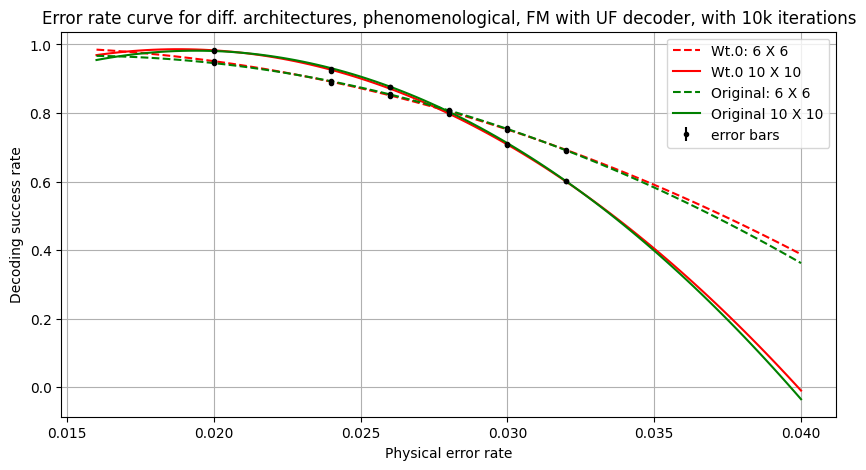

In [30]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.9523],"1":[0.024,0.8889],"2":[0.026,0.8505],"3":[0.028,0.8046],"4":[0.03,0.7574],"5":[0.032,0.6889]},"(10, 10)":{"0":[0.02,0.9831],"1":[0.024,0.9232],"2":[0.026,0.8759],"3":[0.028,0.7963],"4":[0.03,0.7065],"5":[0.032,0.6006]}}
wt_00_data = {"(6, 6)":{"0":[0.02,0.9447],"1":[0.024,0.8947],"2":[0.026,0.8541],"3":[0.028,0.8069],"4":[0.03,0.7509],"5":[0.032,0.6927]},"(10, 10)":{"0":[0.02,0.9815],"1":[0.024,0.929],"2":[0.026,0.8752],"3":[0.028,0.8082],"4":[0.03,0.7104],"5":[0.032,0.6004]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_00_l6 = [rate[1] for rate in list(wt_00_data["(6, 6)"].values())]
wt_00_l10 = [rate[1] for rate in list(wt_00_data["(10, 10)"].values())]



# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt00 = [[err(x) for x in wt00_l] for wt00_l in [wt_00_l6, wt_00_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt00 =[curve_fit(fitting_function, rates, wt00, maxfev=5000) for wt00 in [wt_00_l6, wt_00_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_00_l6,yerr=error_wt00[0], fmt='k.')
plt.errorbar(rates,wt_00_l10,yerr=error_wt00[1], fmt='k.')


plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[0][0][0],pop_wt00[0][0][1],pop_wt00[0][0][2],pop_wt00[0][0][3],pop_wt00[0][0][4]),'g--', label='wt00_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[1][0][0],pop_wt00[1][0][1],pop_wt00[1][0][2],pop_wt00[1][0][3],pop_wt00[1][0][4]),'g-', label='wt00_l10_fit')




plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Original: 6 X 6','Original 10 X 10','error bars'])

plt.savefig('Architectures_original_vs_wt0_comparison_default_layers.pdf')
plt.show()

## Original vs Weight 0 (20 Layers)

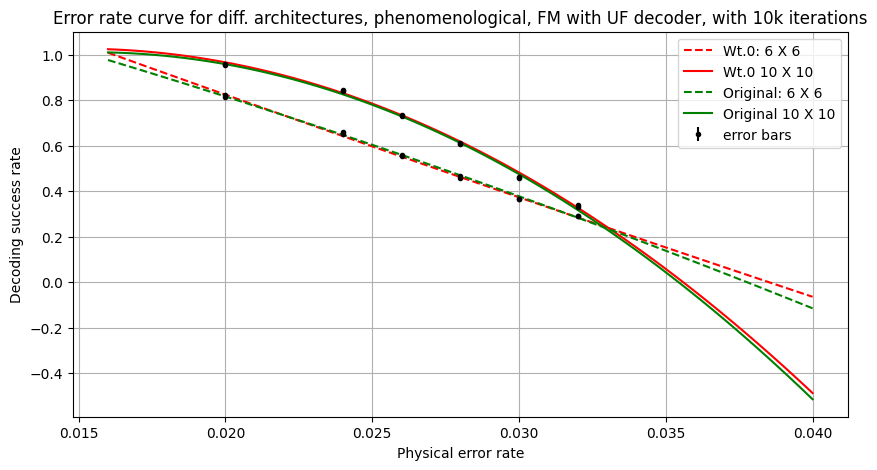

In [31]:
iterations = 10000

wt_0_data = {"(6, 6)":{"0":[0.02,0.8211],"1":[0.024,0.6506],"2":[0.026,0.5544],"3":[0.028,0.4573],"4":[0.03,0.3638],"5":[0.032,0.2919]},"(10, 10)":{"0":[0.02,0.9606],"1":[0.024,0.8458],"2":[0.026,0.7366],"3":[0.028,0.6128],"4":[0.03,0.4635],"5":[0.032,0.3407]}}
wt_00_data = {"(6, 6)":{"0":[0.02,0.8122],"1":[0.024,0.6597],"2":[0.026,0.5581],"3":[0.028,0.4663],"4":[0.03,0.3675],"5":[0.032,0.2917]},"(10, 10)":{"0":[0.02,0.9534],"1":[0.024,0.8388],"2":[0.026,0.7298],"3":[0.028,0.6095],"4":[0.03,0.4576],"5":[0.032,0.3294]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_00_l6 = [rate[1] for rate in list(wt_00_data["(6, 6)"].values())]
wt_00_l10 = [rate[1] for rate in list(wt_00_data["(10, 10)"].values())]



# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt00 = [[err(x) for x in wt00_l] for wt00_l in [wt_00_l6, wt_00_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt00 =[curve_fit(fitting_function, rates, wt00, maxfev=5000) for wt00 in [wt_00_l6, wt_00_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_00_l6,yerr=error_wt00[0], fmt='k.')
plt.errorbar(rates,wt_00_l10,yerr=error_wt00[1], fmt='k.')


plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[0][0][0],pop_wt00[0][0][1],pop_wt00[0][0][2],pop_wt00[0][0][3],pop_wt00[0][0][4]),'g--', label='wt00_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt00[1][0][0],pop_wt00[1][0][1],pop_wt00[1][0][2],pop_wt00[1][0][3],pop_wt00[1][0][4]),'g-', label='wt00_l10_fit')




plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Original: 6 X 6','Original 10 X 10','error bars'])

plt.savefig('Architectures_original_vs_wt0_comparison_20_layers.pdf')
plt.show()

## Error rates comparison for various architectures (Layers = 20)

c:\Users\ssingh8\Anaconda3\envs\qsurf\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


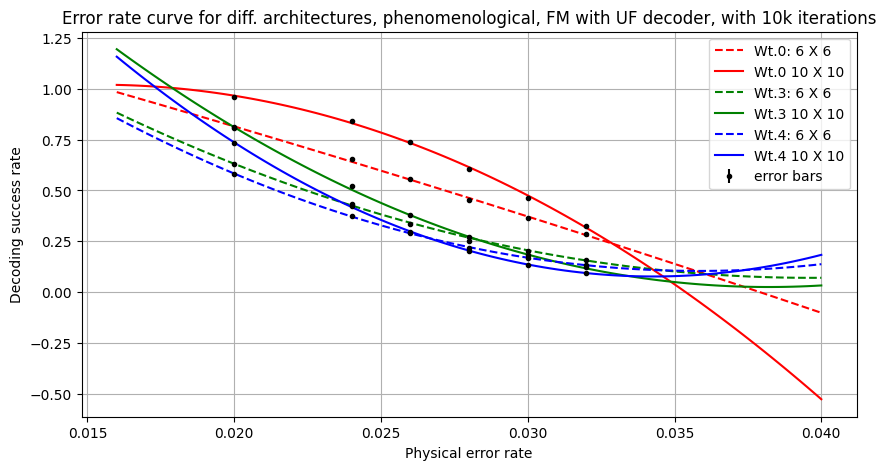

In [14]:
iterations = 10000
# LAYERS = 20, DATA

wt_0_data = {"(6, 6)":{"0":[0.02,0.8104],"1":[0.024,0.6525],"2":[0.026,0.5557],"3":[0.028,0.4518],"4":[0.03,0.365],"5":[0.032,0.2865]},"(10, 10)":{"0":[0.02,0.9606],"1":[0.024,0.8434],"2":[0.026,0.7392],"3":[0.028,0.6038],"4":[0.03,0.4611],"5":[0.032,0.3271]}}
wt_3_data = {"(6, 6)":{"0":[0.02,0.6299],"1":[0.024,0.4308],"2":[0.026,0.3352],"3":[0.028,0.2708],"4":[0.03,0.2015],"5":[0.032,0.1568]},"(10, 10)":{"0":[0.02,0.8046],"1":[0.024,0.5225],"2":[0.026,0.3785],"3":[0.028,0.2522],"4":[0.03,0.1841],"5":[0.032,0.1225]}}
wt_4_data = {"(6, 6)":{"0":[0.02,0.5814],"1":[0.024,0.3756],"2":[0.026,0.2883],"3":[0.028,0.2179],"4":[0.03,0.1672],"5":[0.032,0.1338]},"(10, 10)":{"0":[0.02,0.7351],"1":[0.024,0.4214],"2":[0.026,0.2971],"3":[0.028,0.2024],"4":[0.03,0.134],"5":[0.032,0.0946]}}

rates = [rate[0] for rate in list(wt_0_data["(6, 6)"].values())]

wt_0_l6 = [rate[1] for rate in list(wt_0_data["(6, 6)"].values())]
wt_0_l10 = [rate[1] for rate in list(wt_0_data["(10, 10)"].values())]

wt_3_l6 = [rate[1] for rate in list(wt_3_data["(6, 6)"].values())]
wt_3_l10 = [rate[1] for rate in list(wt_3_data["(10, 10)"].values())]

wt_4_l6 = [rate[1] for rate in list(wt_4_data["(6, 6)"].values())]
wt_4_l10 = [rate[1] for rate in list(wt_4_data["(10, 10)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error_wt0 = [[err(x) for x in wt0_l] for wt0_l in [wt_0_l6, wt_0_l10]]
error_wt3 = [[err(x) for x in wt3_l] for wt3_l in [wt_3_l6, wt_3_l10]]
error_wt4 = [[err(x) for x in wt4_l] for wt4_l in [wt_4_l6, wt_4_l10]]

rng = np.random.default_rng()

pop_wt0 =[curve_fit(fitting_function, rates, wt0, maxfev=5000) for wt0 in [wt_0_l6, wt_0_l10]]
pop_wt3 =[curve_fit(fitting_function, rates, wt3, maxfev=5000) for wt3 in [wt_3_l6, wt_3_l10]]
pop_wt4 =[curve_fit(fitting_function, rates, wt4, maxfev=5000) for wt4 in [wt_4_l6, wt_4_l10]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures, phenomenological, FM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_0_l6,yerr=error_wt0[0], fmt='k.')
plt.errorbar(rates,wt_0_l10,yerr=error_wt0[1], fmt='k.')

plt.errorbar(rates,wt_3_l6,yerr=error_wt3[0], fmt='k.')
plt.errorbar(rates,wt_3_l10,yerr=error_wt3[1], fmt='k.')

plt.errorbar(rates,wt_4_l6,yerr=error_wt4[0], fmt='k.')
plt.errorbar(rates,wt_4_l10,yerr=error_wt4[1], fmt='k.')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[0][0][0],pop_wt0[0][0][1],pop_wt0[0][0][2],pop_wt0[0][0][3],pop_wt0[0][0][4]),'r--', label='wt0_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt0[1][0][0],pop_wt0[1][0][1],pop_wt0[1][0][2],pop_wt0[1][0][3],pop_wt0[1][0][4]),'r-', label='wt0_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[0][0][0],pop_wt3[0][0][1],pop_wt3[0][0][2],pop_wt3[0][0][3],pop_wt3[0][0][4]),'g--', label='wt3_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt3[1][0][0],pop_wt3[1][0][1],pop_wt3[1][0][2],pop_wt3[1][0][3],pop_wt3[1][0][4]),'g-', label='wt3_l10_fit')

plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[0][0][0],pop_wt4[0][0][1],pop_wt4[0][0][2],pop_wt4[0][0][3],pop_wt4[0][0][4]),'b--', label='wt4_l6_fit')
plt.plot(np.linspace(0.016, 0.04, 100),fitting_function(np.linspace(0.016, 0.04, 100),pop_wt4[1][0][0],pop_wt4[1][0][1],pop_wt4[1][0][2],pop_wt4[1][0][3],pop_wt4[1][0][4]),'b-', label='wt4_l10_fit')



plt.legend(['Wt.0: 6 X 6','Wt.0 10 X 10','Wt.3: 6 X 6','Wt.3 10 X 10','Wt.4: 6 X 6','Wt.4 10 X 10','error bars'])

plt.savefig('Architectures comparison_20layers.pdf')
plt.show()

## Architecture comparisons with Perfect Measurements (Layer = 1) [No Decoding]

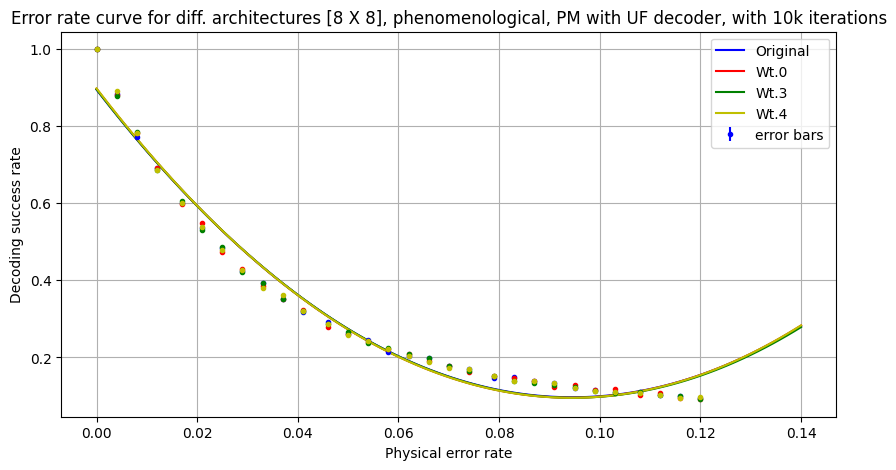

In [20]:
iterations = 10000
# LAYERS = 1, Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.8819],"2":[0.008,0.7711],"3":[0.012,0.6908],"4":[0.017,0.6014],"5":[0.021,0.5364],"6":[0.025,0.4831],"7":[0.029,0.4232],"8":[0.033,0.3923],"9":[0.037,0.3512],"10":[0.041,0.3183],"11":[0.046,0.2909],"12":[0.05,0.2605],"13":[0.054,0.2455],"14":[0.058,0.2136],"15":[0.062,0.2045],"16":[0.066,0.1994],"17":[0.07,0.1769],"18":[0.074,0.1688],"19":[0.079,0.1476],"20":[0.083,0.1483],"21":[0.087,0.1394],"22":[0.091,0.1335],"23":[0.095,0.1211],"24":[0.099,0.1146],"25":[0.103,0.1117],"26":[0.108,0.1102],"27":[0.112,0.1027],"28":[0.116,0.0997],"29":[0.12,0.095]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.8792],"2":[0.008,0.7829],"3":[0.012,0.6911],"4":[0.017,0.5973],"5":[0.021,0.5472],"6":[0.025,0.4743],"7":[0.029,0.4285],"8":[0.033,0.3863],"9":[0.037,0.3516],"10":[0.041,0.3232],"11":[0.046,0.2778],"12":[0.05,0.2605],"13":[0.054,0.2388],"14":[0.058,0.223],"15":[0.062,0.2079],"16":[0.066,0.1907],"17":[0.07,0.1776],"18":[0.074,0.1618],"19":[0.079,0.1517],"20":[0.083,0.1469],"21":[0.087,0.1378],"22":[0.091,0.1237],"23":[0.095,0.1277],"24":[0.099,0.1144],"25":[0.103,0.1185],"26":[0.108,0.1026],"27":[0.112,0.1083],"28":[0.116,0.0959],"29":[0.12,0.0924]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.8767],"2":[0.008,0.7851],"3":[0.012,0.6861],"4":[0.017,0.6044],"5":[0.021,0.5298],"6":[0.025,0.4851],"7":[0.029,0.4205],"8":[0.033,0.392],"9":[0.037,0.3516],"10":[0.041,0.3194],"11":[0.046,0.2878],"12":[0.05,0.2651],"13":[0.054,0.2383],"14":[0.058,0.2235],"15":[0.062,0.2089],"16":[0.066,0.1978],"17":[0.07,0.1787],"18":[0.074,0.1654],"19":[0.079,0.153],"20":[0.083,0.1391],"21":[0.087,0.1334],"22":[0.091,0.1282],"23":[0.095,0.1227],"24":[0.099,0.1139],"25":[0.103,0.1075],"26":[0.108,0.1093],"27":[0.112,0.103],"28":[0.116,0.1009],"29":[0.12,0.0921]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.004,0.8895],"2":[0.008,0.7822],"3":[0.012,0.6853],"4":[0.017,0.6001],"5":[0.021,0.537],"6":[0.025,0.4789],"7":[0.029,0.4265],"8":[0.033,0.3787],"9":[0.037,0.3613],"10":[0.041,0.3211],"11":[0.046,0.2859],"12":[0.05,0.2594],"13":[0.054,0.2438],"14":[0.058,0.2214],"15":[0.062,0.203],"16":[0.066,0.189],"17":[0.07,0.1721],"18":[0.074,0.1707],"19":[0.079,0.1524],"20":[0.083,0.1394],"21":[0.087,0.1394],"22":[0.091,0.1334],"23":[0.095,0.1218],"24":[0.099,0.1123],"25":[0.103,0.1113],"26":[0.108,0.1091],"27":[0.112,0.1029],"28":[0.116,0.0947],"29":[0.12,0.097]}}
rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, PM with UF decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.14, 100),fitting_function(np.linspace(0.0, 0.14, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_1layer_PM.pdf')
plt.show()

## Architecture comparisons with Faulty Measurements (Layer = 1) [No Decoding]

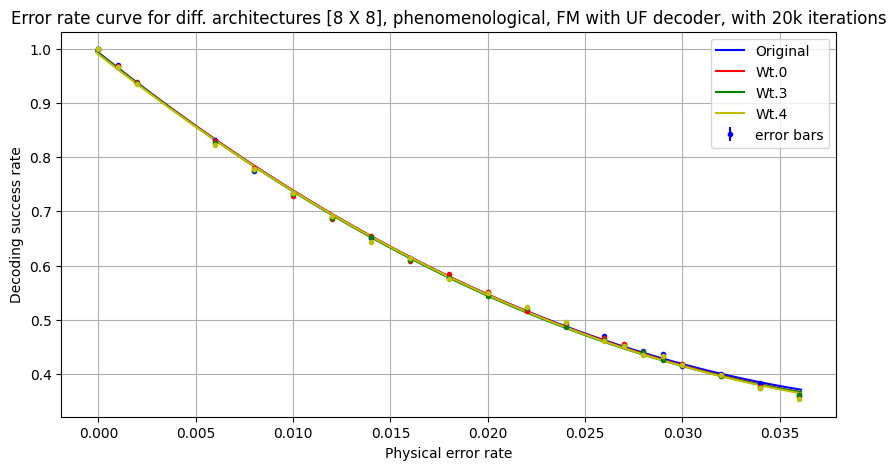

In [49]:
iterations = 20000
# LAYERS = 1, Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.96945],"2":[0.002,0.93715],"3":[0.006,0.8314],"4":[0.008,0.77375],"5":[0.01,0.7337],"6":[0.012,0.6889],"7":[0.014,0.65155],"8":[0.016,0.6137],"9":[0.018,0.5779],"10":[0.02,0.55035],"11":[0.022,0.51715],"12":[0.024,0.4933],"13":[0.026,0.46925],"14":[0.027,0.4539],"15":[0.028,0.4418],"16":[0.029,0.4372],"17":[0.03,0.4146],"18":[0.032,0.4007],"19":[0.034,0.38375],"20":[0.036,0.3616]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9677],"2":[0.002,0.93805],"3":[0.006,0.8297],"4":[0.008,0.78035],"5":[0.01,0.72795],"6":[0.012,0.68595],"7":[0.014,0.65375],"8":[0.016,0.6078],"9":[0.018,0.5838],"10":[0.02,0.55135],"11":[0.022,0.5168],"12":[0.024,0.49125],"13":[0.026,0.4664],"14":[0.027,0.45475],"15":[0.028,0.44045],"16":[0.029,0.4322],"17":[0.03,0.4177],"18":[0.032,0.3973],"19":[0.034,0.376],"20":[0.036,0.3575]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9667],"2":[0.002,0.9361],"3":[0.006,0.8267],"4":[0.008,0.7763],"5":[0.01,0.7324],"6":[0.012,0.6876],"7":[0.014,0.65195],"8":[0.016,0.60965],"9":[0.018,0.5775],"10":[0.02,0.5434],"11":[0.022,0.52265],"12":[0.024,0.4874],"13":[0.026,0.4635],"14":[0.027,0.45115],"15":[0.028,0.44],"16":[0.029,0.42565],"17":[0.03,0.41605],"18":[0.032,0.3964],"19":[0.034,0.3751],"20":[0.036,0.3617]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9653],"2":[0.002,0.9353],"3":[0.006,0.8222],"4":[0.008,0.77855],"5":[0.01,0.73395],"6":[0.012,0.69065],"7":[0.014,0.6438],"8":[0.016,0.61305],"9":[0.018,0.57555],"10":[0.02,0.549],"11":[0.022,0.5227],"12":[0.024,0.4959],"13":[0.026,0.4613],"14":[0.027,0.4517],"15":[0.028,0.4346],"16":[0.029,0.43345],"17":[0.03,0.4166],"18":[0.032,0.39865],"19":[0.034,0.3746],"20":[0.036,0.3539]}}
rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_1layer_FM_noDecoding.pdf')
plt.show()

## Architecture comparisons with Faulty Measurements [Default Layers]]

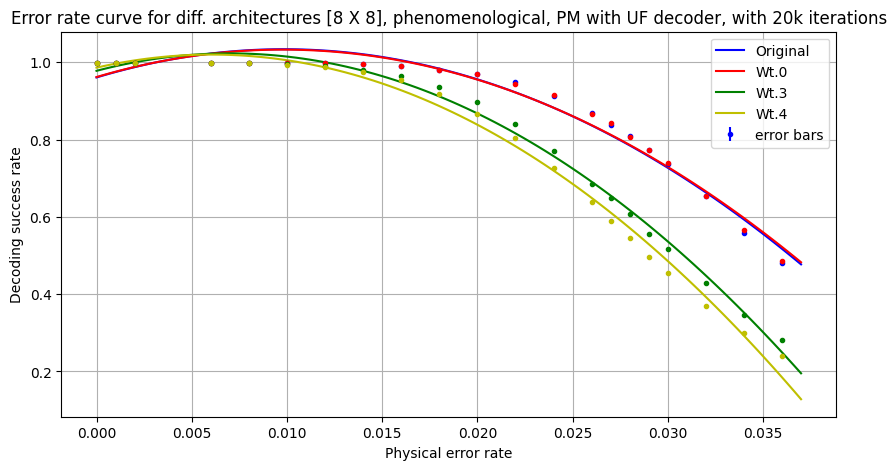

In [44]:
iterations = 20000
# Lattice: 8 X 8 
wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99835],"4":[0.008,0.99835],"5":[0.01,0.9982],"6":[0.012,0.997],"7":[0.014,0.9948],"8":[0.016,0.99045],"9":[0.018,0.9813],"10":[0.02,0.96965],"11":[0.022,0.948],"12":[0.024,0.9116],"13":[0.026,0.8695],"14":[0.027,0.83735],"15":[0.028,0.8096],"16":[0.029,0.7743],"17":[0.03,0.73575],"18":[0.032,0.65475],"19":[0.034,0.5592],"20":[0.036,0.4803]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9984],"4":[0.008,0.9983],"5":[0.01,0.9978],"6":[0.012,0.9972],"7":[0.014,0.99445],"8":[0.016,0.9909],"9":[0.018,0.9808],"10":[0.02,0.9686],"11":[0.022,0.94305],"12":[0.024,0.91425],"13":[0.026,0.86675],"14":[0.027,0.84275],"15":[0.028,0.808],"16":[0.029,0.77295],"17":[0.03,0.73975],"18":[0.032,0.6549],"19":[0.034,0.56635],"20":[0.036,0.486]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99825],"4":[0.008,0.99735],"5":[0.01,0.99505],"6":[0.012,0.98955],"7":[0.014,0.98115],"8":[0.016,0.9648],"9":[0.018,0.93575],"10":[0.02,0.8969],"11":[0.022,0.8398],"12":[0.024,0.77],"13":[0.026,0.6861],"14":[0.027,0.6482],"15":[0.028,0.6071],"16":[0.029,0.5555],"17":[0.03,0.51645],"18":[0.032,0.43005],"19":[0.034,0.34735],"20":[0.036,0.28145]}}
wt_4_data =  {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99805],"4":[0.008,0.9974],"5":[0.01,0.9935],"6":[0.012,0.9873],"7":[0.014,0.97565],"8":[0.016,0.953],"9":[0.018,0.91745],"10":[0.02,0.8665],"11":[0.022,0.8033],"12":[0.024,0.7278],"13":[0.026,0.63885],"14":[0.027,0.5899],"15":[0.028,0.54495],"16":[0.029,0.49545],"17":[0.03,0.45605],"18":[0.032,0.37025],"19":[0.034,0.3005],"20":[0.036,0.23975]}}

rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=5000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=5000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=5000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=5000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, PM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_defaultlayer_FM.pdf')
plt.show()

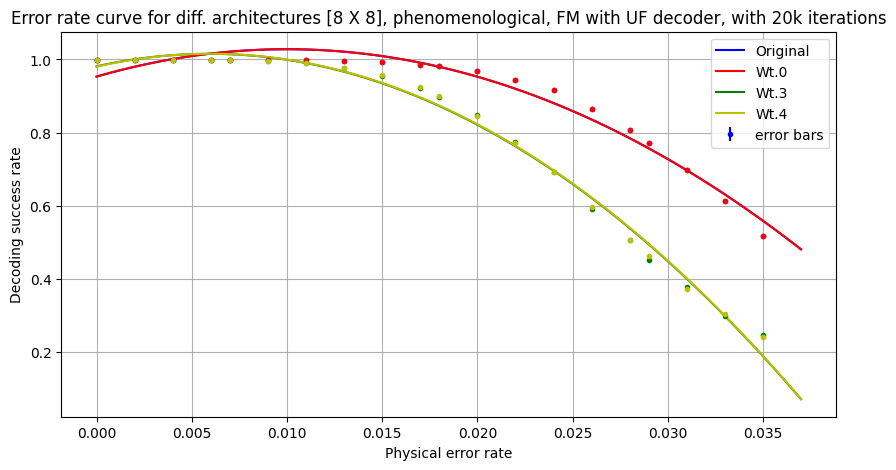

In [2]:
iterations = 10000
# Lattice: 8 X 8 
# wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9984],"4":[0.008,0.9984],"5":[0.01,0.998],"6":[0.012,0.9972],"7":[0.014,0.9958],"8":[0.016,0.9897],"9":[0.018,0.9808],"10":[0.02,0.9665],"11":[0.022,0.948],"12":[0.024,0.9095],"13":[0.026,0.865],"14":[0.027,0.8343],"15":[0.028,0.8062],"16":[0.029,0.7806],"17":[0.03,0.7396],"18":[0.032,0.6531],"19":[0.034,0.5653],"20":[0.036,0.4808]}}
# wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9984],"4":[0.008,0.9984],"5":[0.01,0.998],"6":[0.012,0.9972],"7":[0.014,0.9958],"8":[0.016,0.9897],"9":[0.018,0.9808],"10":[0.02,0.9665],"11":[0.022,0.948],"12":[0.024,0.9095],"13":[0.026,0.865],"14":[0.027,0.8343],"15":[0.028,0.8062],"16":[0.029,0.7806],"17":[0.03,0.7396],"18":[0.032,0.6531],"19":[0.034,0.5653],"20":[0.036,0.4808]}}
# wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9983],"4":[0.008,0.9981],"5":[0.01,0.9982],"6":[0.012,0.9965],"7":[0.014,0.995],"8":[0.016,0.9888],"9":[0.018,0.9811],"10":[0.02,0.968],"11":[0.022,0.9417],"12":[0.024,0.9021],"13":[0.026,0.8603],"14":[0.027,0.8267],"15":[0.028,0.794],"16":[0.029,0.763],"17":[0.03,0.7249],"18":[0.032,0.6361],"19":[0.034,0.5495],"20":[0.036,0.4599]}}
# wt_4_data =  {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9983],"4":[0.008,0.9983],"5":[0.01,0.9975],"6":[0.012,0.9971],"7":[0.014,0.9953],"8":[0.016,0.9879],"9":[0.018,0.9799],"10":[0.02,0.965],"11":[0.022,0.9416],"12":[0.024,0.9074],"13":[0.026,0.8576],"14":[0.027,0.828],"15":[0.028,0.7937],"16":[0.029,0.7622],"17":[0.03,0.7199],"18":[0.032,0.6386],"19":[0.034,0.5461],"20":[0.036,0.4536]}}

# wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99825],"4":[0.008,0.99825],"5":[0.01,0.99805],"6":[0.012,0.99685],"7":[0.014,0.9946],"8":[0.016,0.9904],"9":[0.018,0.9821],"10":[0.02,0.97005],"11":[0.022,0.946],"12":[0.024,0.91395],"13":[0.026,0.86775],"14":[0.027,0.8383],"15":[0.028,0.81225],"16":[0.029,0.77165],"17":[0.03,0.7337],"18":[0.032,0.65475],"19":[0.034,0.57115],"20":[0.036,0.4801]}}
# wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99825],"4":[0.008,0.99825],"5":[0.01,0.99805],"6":[0.012,0.99685],"7":[0.014,0.9946],"8":[0.016,0.9904],"9":[0.018,0.9821],"10":[0.02,0.97005],"11":[0.022,0.946],"12":[0.024,0.91395],"13":[0.026,0.86775],"14":[0.027,0.8383],"15":[0.028,0.81225],"16":[0.029,0.77165],"17":[0.03,0.7337],"18":[0.032,0.65475],"19":[0.034,0.57115],"20":[0.036,0.4801]}}
# wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.99835],"4":[0.008,0.99815],"5":[0.01,0.9978],"6":[0.012,0.99685],"7":[0.014,0.9954],"8":[0.016,0.99095],"9":[0.018,0.98255],"10":[0.02,0.96915],"11":[0.022,0.9458],"12":[0.024,0.91335],"13":[0.026,0.86685],"14":[0.027,0.8389],"15":[0.028,0.80785],"16":[0.029,0.77105],"17":[0.03,0.7287],"18":[0.032,0.65395],"19":[0.034,0.5619],"20":[0.036,0.479]}}
# wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9983],"4":[0.008,0.99835],"5":[0.01,0.9981],"6":[0.012,0.99695],"7":[0.014,0.9944],"8":[0.016,0.9903],"9":[0.018,0.98435],"10":[0.02,0.9712],"11":[0.022,0.94695],"12":[0.024,0.91115],"13":[0.026,0.86845],"14":[0.027,0.8404],"15":[0.028,0.80385],"16":[0.029,0.7725],"17":[0.03,0.73545],"18":[0.032,0.65405],"19":[0.034,0.57245],"20":[0.036,0.47265]}}

wt_00_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.002,0.9984],"2":[0.004,0.9984],"3":[0.006,0.9984],"4":[0.007,0.9984],"5":[0.009,0.9982],"6":[0.011,0.9975],"7":[0.013,0.99635],"8":[0.015,0.99385],"9":[0.017,0.98585],"10":[0.018,0.9835],"11":[0.02,0.969],"12":[0.022,0.9452],"13":[0.024,0.9168],"14":[0.026,0.8648],"15":[0.028,0.8063],"16":[0.029,0.7716],"17":[0.031,0.69695],"18":[0.033,0.61205],"19":[0.035,0.5169]}}
wt_0_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.002,0.9984],"2":[0.004,0.9984],"3":[0.006,0.9984],"4":[0.007,0.9984],"5":[0.009,0.9982],"6":[0.011,0.9975],"7":[0.013,0.99635],"8":[0.015,0.99385],"9":[0.017,0.98585],"10":[0.018,0.9835],"11":[0.02,0.969],"12":[0.022,0.9452],"13":[0.024,0.9168],"14":[0.026,0.8648],"15":[0.028,0.8063],"16":[0.029,0.7716],"17":[0.031,0.69695],"18":[0.033,0.61205],"19":[0.035,0.5169]}}
wt_3_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.002,0.9984],"2":[0.004,0.9984],"3":[0.006,0.99815],"4":[0.007,0.9976],"5":[0.009,0.9952],"6":[0.011,0.9895],"7":[0.013,0.9762],"8":[0.015,0.95445],"9":[0.017,0.9214],"10":[0.018,0.89855],"11":[0.02,0.8487],"12":[0.022,0.7741],"13":[0.024,0.6925],"14":[0.026,0.5903],"15":[0.028,0.50615],"16":[0.029,0.452],"17":[0.031,0.37735],"18":[0.033,0.29855],"19":[0.035,0.24665]}}
wt_4_data = {"(8, 8)":{"0":[0.0,0.9984],"1":[0.002,0.99835],"2":[0.004,0.9984],"3":[0.006,0.99795],"4":[0.007,0.9976],"5":[0.009,0.9946],"6":[0.011,0.9894],"7":[0.013,0.977],"8":[0.015,0.957],"9":[0.017,0.9247],"10":[0.018,0.8996],"11":[0.02,0.84585],"12":[0.022,0.7704],"13":[0.024,0.6933],"14":[0.026,0.59555],"15":[0.028,0.5053],"16":[0.029,0.4639],"17":[0.031,0.3735],"18":[0.033,0.30395],"19":[0.035,0.24175]}}


rates = [rate[0] for rate in list(wt_0_data["(8, 8)"].values())]

wt_00 = wt_0 = [rate[1] for rate in list(wt_00_data["(8, 8)"].values())]

wt_0 = [rate[1] for rate in list(wt_0_data["(8, 8)"].values())]

wt_3 = [rate[1] for rate in list(wt_3_data["(8, 8)"].values())]

wt_4 = [rate[1] for rate in list(wt_4_data["(8, 8)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)

error_wt00 = [err(x) for x in wt_00]
error_wt0 = [err(x) for x in wt_0]
error_wt3 = [err(x) for x in wt_3]
error_wt4 = [err(x) for x in wt_4]

rng = np.random.default_rng()

pop_wt00, _ = curve_fit(fitting_function, rates, wt_00, maxfev=50000)
pop_wt0, _ = curve_fit(fitting_function, rates, wt_0, maxfev=50000)
pop_wt3, _ = curve_fit(fitting_function, rates, wt_3, maxfev=50000)
pop_wt4, _ = curve_fit(fitting_function, rates, wt_4, maxfev=50000)


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Error rate curve for diff. architectures [8 X 8], phenomenological, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Physical error rate')
plt.grid()

plt.errorbar(rates,wt_00,yerr=error_wt0[0], fmt='b.')

plt.errorbar(rates,wt_0,yerr=error_wt0[0], fmt='r.')

plt.errorbar(rates,wt_3,yerr=error_wt3[0], fmt='g.')

plt.errorbar(rates,wt_4,yerr=error_wt4[0], fmt='y.')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt00[0],pop_wt00[1],pop_wt00[2],pop_wt00[3],pop_wt00[4]),'b-', label='wt00_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt0[0],pop_wt0[1],pop_wt0[2],pop_wt0[3],pop_wt0[4]),'r-', label='wt0_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt3[0],pop_wt3[1],pop_wt3[2],pop_wt3[3],pop_wt3[4]),'g-', label='wt3_fit')

plt.plot(np.linspace(0.0, 0.037, 100),fitting_function(np.linspace(0.0, 0.037, 100),pop_wt4[0],pop_wt4[1],pop_wt4[2],pop_wt4[3],pop_wt4[4]),'y-', label='wt4_fit')




plt.legend(['Original','Wt.0','Wt.3','Wt.4','error bars'])

plt.savefig('Architectures comparison_defaultlayer_FM_after_extra_measurements.pdf')
plt.show()

# Weight 4 architecture simulations

## Weight 4 scattering threshold

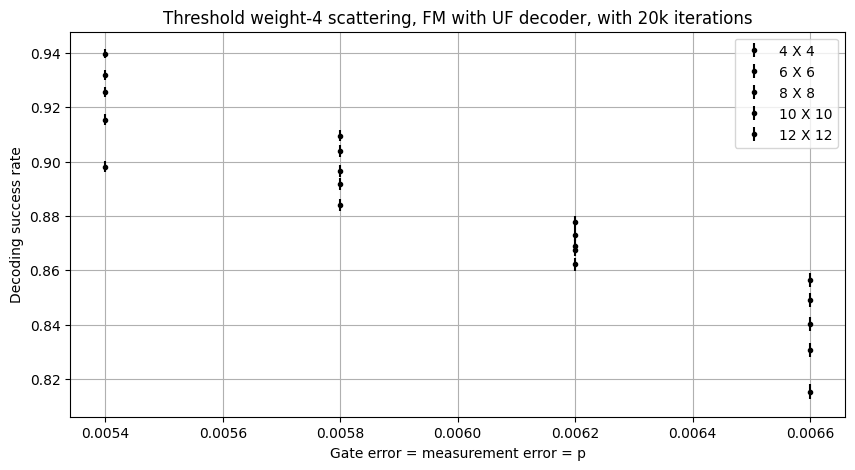

In [9]:
# UNION FIND
iterations = 20000

# data = {"(4, 4)":{"0":[0.0045,0.9206],"1":[0.00475,0.9166],"2":[0.005,0.91065],"3":[0.00525,0.9007],"4":[0.0054,0.8961],"5":[0.0055,0.89415],"6":[0.0056,0.88995],"7":[0.0057,0.89055],"8":[0.0058,0.8892],"9":[0.0059,0.8775]},"(6, 6)":{"0":[0.0045,0.94855],"1":[0.00475,0.94035],"2":[0.005,0.93355],"3":[0.00525,0.9231],"4":[0.0054,0.9124],"5":[0.0055,0.90895],"6":[0.0056,0.90895],"7":[0.0057,0.90365],"8":[0.0058,0.8973],"9":[0.0059,0.8922]},"(8, 8)":{"0":[0.0045,0.95975],"1":[0.00475,0.9526],"2":[0.005,0.94315],"3":[0.00525,0.9327],"4":[0.0054,0.92695],"5":[0.0055,0.92225],"6":[0.0056,0.91385],"7":[0.0057,0.9054],"8":[0.0058,0.8997],"9":[0.0059,0.8946]},"(10, 10)":{"0":[0.0045,0.97255],"1":[0.00475,0.96395],"2":[0.005,0.9568],"3":[0.00525,0.9417],"4":[0.0054,0.9362],"5":[0.0055,0.92305],"6":[0.0056,0.91975],"7":[0.0057,0.91175],"8":[0.0058,0.9056],"9":[0.0059,0.89575]},"(12, 12)":{"0":[0.0045,0.97825],"1":[0.00475,0.97075],"2":[0.005,0.96055],"3":[0.00525,0.94945],"4":[0.0054,0.93835],"5":[0.0055,0.9332],"6":[0.0056,0.92225],"7":[0.0057,0.91445],"8":[0.0058,0.907],"9":[0.0059,0.8976]}}
data = {"(4, 4)":{"0":[0.0054,0.89815],"1":[0.0058,0.88405],"2":[0.0062,0.8676],"3":[0.0066,0.8565]},"(6, 6)":{"0":[0.0054,0.91535],"1":[0.0058,0.89165],"2":[0.0062,0.8777],"3":[0.0066,0.8492]},"(8, 8)":{"0":[0.0054,0.92555],"1":[0.0058,0.89655],"2":[0.0062,0.8731],"3":[0.0066,0.8401]},"(10, 10)":{"0":[0.0054,0.9317],"1":[0.0058,0.90385],"2":[0.0062,0.86905],"3":[0.0066,0.8308]},"(12, 12)":{"0":[0.0054,0.9396],"1":[0.0058,0.90945],"2":[0.0062,0.86215],"3":[0.0066,0.81535]}}
rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

# pop =[curve_fit(fitting_function, rates, code, maxfev=50000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-4 scattering, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_4_scattering_threshold.pdf')
plt.show()

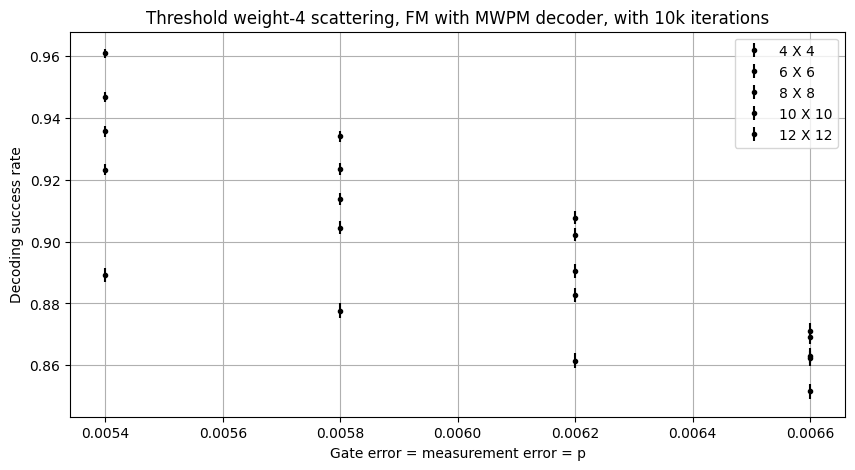

In [10]:
# MWPM
iterations = 20000

data = {"(4, 4)":{"0":[0.0054,0.8893],"1":[0.0058,0.8777],"2":[0.0062,0.8614],"3":[0.0066,0.8515]},"(6, 6)":{"0":[0.0054,0.9233],"1":[0.0058,0.9045],"2":[0.0062,0.8826],"3":[0.0066,0.863]},"(8, 8)":{"0":[0.0054,0.9357],"1":[0.0058,0.9139],"2":[0.0062,0.8905],"3":[0.0066,0.8623]},"(10, 10)":{"0":[0.0054,0.9468],"1":[0.0058,0.9235],"2":[0.0062,0.9022],"3":[0.0066,0.8692]},"(12, 12)":{"0":[0.0054,0.9609],"1":[0.0058,0.9341],"2":[0.0062,0.9078],"3":[0.0066,0.8712]}}
rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

# pop =[curve_fit(fitting_function, rates, code, maxfev=50000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-4 scattering, FM with MWPM decoder, with 10k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_4_scattering_threshold_MWPM.pdf')
plt.show()

## Weight 4 emission threshold

c:\Users\ssingh8\Anaconda3\envs\qsurf\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


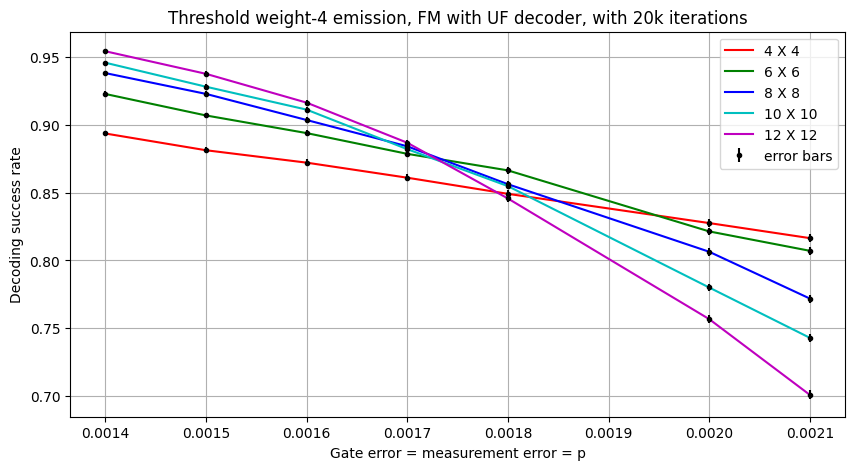

In [5]:
iterations = 20000

# data = {"(4, 4)":{"0":[0.0014,0.8936],"1":[0.0015,0.88125],"2":[0.0016,0.8721],"3":[0.0017,0.861],"4":[0.0018,0.8491],"5":[0.002,0.82755],"6":[0.0021,0.81645]},"(6, 6)":{"0":[0.0014,0.92275],"1":[0.0015,0.9069],"2":[0.0016,0.8939],"3":[0.0017,0.8786],"4":[0.0018,0.8664],"5":[0.002,0.8214],"6":[0.0021,0.8071]},"(8, 8)":{"0":[0.0014,0.93815],"1":[0.0015,0.9228],"2":[0.0016,0.90355],"3":[0.0017,0.88415],"4":[0.0018,0.8562],"5":[0.002,0.8064],"6":[0.0021,0.7719]},"(10, 10)":{"0":[0.0014,0.9458],"1":[0.0015,0.9281],"2":[0.0016,0.9112],"3":[0.0017,0.88205],"4":[0.0018,0.8548],"5":[0.002,0.78005],"6":[0.0021,0.74295]},"(12, 12)":{"0":[0.0014,0.95425],"1":[0.0015,0.9376],"2":[0.0016,0.91635],"3":[0.0017,0.8868],"4":[0.0018,0.8457],"5":[0.002,0.75675],"6":[0.0021,0.7009]}}
data = {"(4, 4)":{"0":[0.0014,0.8936],"1":[0.0015,0.88125],"2":[0.0016,0.8721],"3":[0.0017,0.861],"4":[0.0018,0.8491],"5":[0.002,0.82755],"6":[0.0021,0.81645]},"(6, 6)":{"0":[0.0014,0.92275],"1":[0.0015,0.9069],"2":[0.0016,0.8939],"3":[0.0017,0.8786],"4":[0.0018,0.8664],"5":[0.002,0.8214],"6":[0.0021,0.8071]},"(8, 8)":{"0":[0.0014,0.93815],"1":[0.0015,0.9228],"2":[0.0016,0.90355],"3":[0.0017,0.88415],"4":[0.0018,0.8562],"5":[0.002,0.8064],"6":[0.0021,0.7719]},"(10, 10)":{"0":[0.0014,0.9458],"1":[0.0015,0.9281],"2":[0.0016,0.9112],"3":[0.0017,0.88205],"4":[0.0018,0.8548],"5":[0.002,0.78005],"6":[0.0021,0.74295]},"(12, 12)":{"0":[0.0014,0.95425],"1":[0.0015,0.9376],"2":[0.0016,0.91635],"3":[0.0017,0.8868],"4":[0.0018,0.8457],"5":[0.002,0.75675],"6":[0.0021,0.7009]}}
rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

pop =[curve_fit(fitting_function, rates, code, maxfev=35000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-4 emission, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')

plt.plot(rates,l4,'r-', label='l4_fit')
plt.plot(rates,l6,'g-', label='l6_fit')
plt.plot(rates,l8,'b-', label='l8_fit')
plt.plot(rates,l10,'c-', label='l10_fit')
plt.plot(rates,l12,'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_4_emission_threshold.pdf')
plt.show()

# Weight 3 architecture simulations

## Weight 3 phenomenological threshold

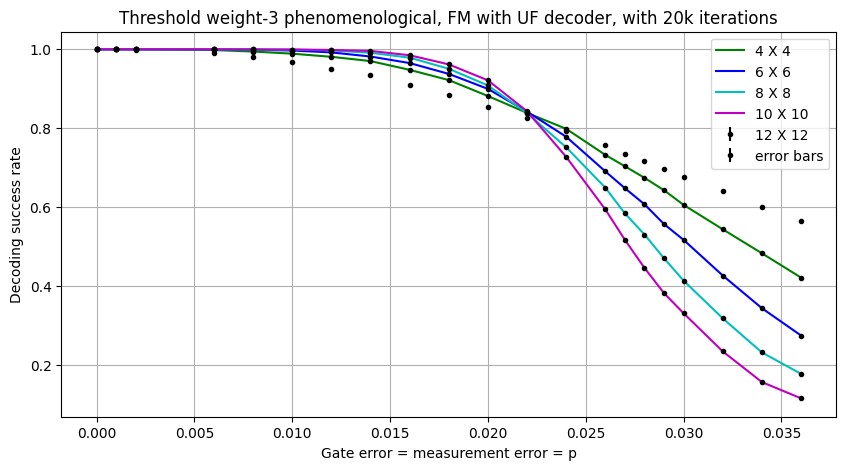

In [3]:
iterations = 20000

data = {"(4, 4)":{"0":[0.0,0.9984],"1":[0.001,0.99815],"2":[0.002,0.9975],"3":[0.006,0.98835],"4":[0.008,0.9786],"5":[0.01,0.9655],"6":[0.012,0.94945],"7":[0.014,0.9333],"8":[0.016,0.90825],"9":[0.018,0.8817],"10":[0.02,0.85355],"11":[0.022,0.8249],"12":[0.024,0.79135],"13":[0.026,0.7563],"14":[0.027,0.73415],"15":[0.028,0.71475],"16":[0.029,0.69535],"17":[0.03,0.675],"18":[0.032,0.6407],"19":[0.034,0.59955],"20":[0.036,0.56405]},"(6, 6)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.99835],"3":[0.006,0.9966],"4":[0.008,0.9928],"5":[0.01,0.98745],"6":[0.012,0.97945],"7":[0.014,0.96865],"8":[0.016,0.94645],"9":[0.018,0.9205],"10":[0.02,0.88015],"11":[0.022,0.8374],"12":[0.024,0.79705],"13":[0.026,0.731],"14":[0.027,0.7022],"15":[0.028,0.6729],"16":[0.029,0.6415],"17":[0.03,0.6043],"18":[0.032,0.54255],"19":[0.034,0.4818],"20":[0.036,0.4202]},"(8, 8)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9983],"4":[0.008,0.99745],"5":[0.01,0.9954],"6":[0.012,0.99065],"7":[0.014,0.98015],"8":[0.016,0.96365],"9":[0.018,0.9362],"10":[0.02,0.8982],"11":[0.022,0.84055],"12":[0.024,0.777],"13":[0.026,0.68925],"14":[0.027,0.64665],"15":[0.028,0.6059],"16":[0.029,0.55575],"17":[0.03,0.5157],"18":[0.032,0.42545],"19":[0.034,0.3427],"20":[0.036,0.27355]},"(10, 10)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9984],"4":[0.008,0.9981],"5":[0.01,0.9977],"6":[0.012,0.99575],"7":[0.014,0.98965],"8":[0.016,0.9773],"9":[0.018,0.94915],"10":[0.02,0.90695],"11":[0.022,0.83685],"12":[0.024,0.7503],"13":[0.026,0.6479],"14":[0.027,0.58285],"15":[0.028,0.52935],"16":[0.029,0.4691],"17":[0.03,0.41255],"18":[0.032,0.31705],"19":[0.034,0.23065],"20":[0.036,0.1765]},"(12, 12)":{"0":[0.0,0.9984],"1":[0.001,0.9984],"2":[0.002,0.9984],"3":[0.006,0.9984],"4":[0.008,0.9983],"5":[0.01,0.99795],"6":[0.012,0.99675],"7":[0.014,0.9944],"8":[0.016,0.9834],"9":[0.018,0.96025],"10":[0.02,0.9199],"11":[0.022,0.84155],"12":[0.024,0.72595],"13":[0.026,0.59285],"14":[0.027,0.5158],"15":[0.028,0.44475],"16":[0.029,0.3808],"17":[0.03,0.3299],"18":[0.032,0.2333],"19":[0.034,0.1556],"20":[0.036,0.11445]}}

rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

pop =[curve_fit(fitting_function, rates, code, maxfev=35000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-3 phenomenological, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
# plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')


plt.plot(rates,l6,'g-', label='l6_fit')
plt.plot(rates,l8,'b-', label='l8_fit')
plt.plot(rates,l10,'c-', label='l10_fit')
plt.plot(rates,l12,'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_3_phenomenological_threshold.pdf')
plt.show()

## Weight 3 scattering threshold

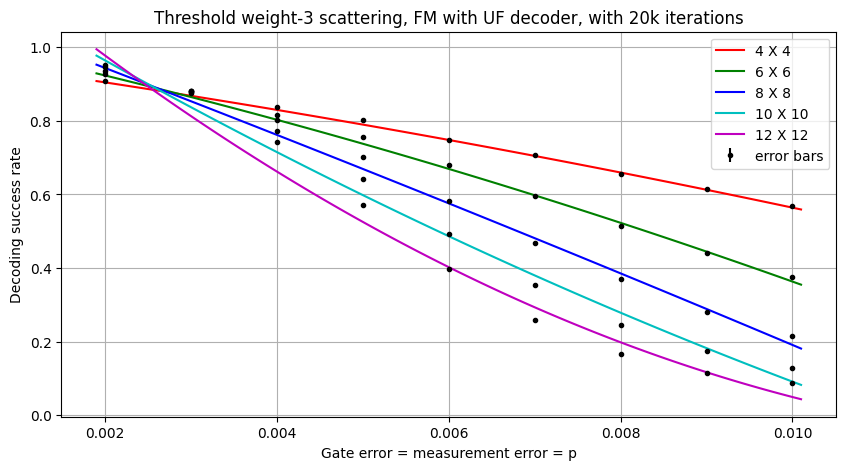

In [2]:
iterations = 20000

data = {"(4, 4)":{"0":[0.002,0.90795],"1":[0.003,0.87645],"2":[0.004,0.83725],"3":[0.005,0.8029],"4":[0.006,0.74845],"5":[0.007,0.70745],"6":[0.008,0.6562],"7":[0.009,0.61385],"8":[0.01,0.5679]},"(6, 6)":{"0":[0.002,0.9261],"1":[0.003,0.8798],"2":[0.004,0.81715],"3":[0.005,0.7556],"4":[0.006,0.6803],"5":[0.007,0.59705],"6":[0.008,0.5144],"7":[0.009,0.4418],"8":[0.01,0.3745]},"(8, 8)":{"0":[0.002,0.93565],"1":[0.003,0.8812],"2":[0.004,0.8022],"3":[0.005,0.7007],"4":[0.006,0.58265],"5":[0.007,0.4668],"6":[0.008,0.3701],"7":[0.009,0.2814],"8":[0.01,0.21545]},"(10, 10)":{"0":[0.002,0.9476],"1":[0.003,0.8815],"2":[0.004,0.77305],"3":[0.005,0.64325],"4":[0.006,0.49395],"5":[0.007,0.3548],"6":[0.008,0.24645],"7":[0.009,0.17435],"8":[0.01,0.1279]},"(12, 12)":{"0":[0.002,0.9525],"1":[0.003,0.8787],"2":[0.004,0.74195],"3":[0.005,0.5716],"4":[0.006,0.3965],"5":[0.007,0.2597],"6":[0.008,0.1659],"7":[0.009,0.1136],"8":[0.01,0.08735]}}

rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

pop =[curve_fit(fitting_function, rates, code, maxfev=35000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-3 scattering, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')

# plt.plot(rates,l4,'r-', label='l4_fit')
# plt.plot(rates,l6,'g-', label='l6_fit')
# plt.plot(rates,l8,'b-', label='l8_fit')
# plt.plot(rates,l10,'c-', label='l10_fit')
# plt.plot(rates,l12,'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_3_scattering_threshold.pdf')
plt.show()

## Weight 3 emission threshold

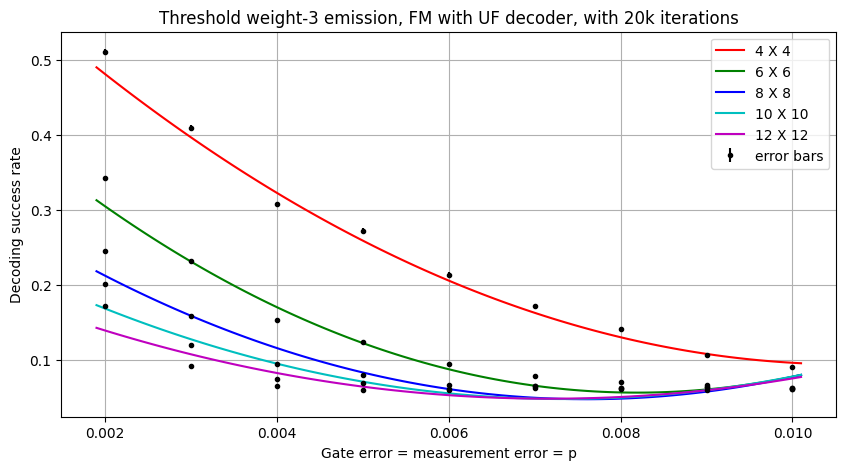

In [51]:
iterations = 20000

data = {"(4, 4)":{"0":[0.002,0.51025],"1":[0.003,0.4089],"2":[0.004,0.30765],"3":[0.005,0.272],"4":[0.006,0.2137],"5":[0.007,0.17165],"6":[0.008,0.1409],"7":[0.009,0.10625],"8":[0.01,0.09055]},"(6, 6)":{"0":[0.002,0.34225],"1":[0.003,0.2316],"2":[0.004,0.15325],"3":[0.005,0.1236],"4":[0.006,0.0944],"5":[0.007,0.079],"6":[0.008,0.07065],"7":[0.009,0.06645],"8":[0.01,0.0619]},"(8, 8)":{"0":[0.002,0.24525],"1":[0.003,0.1583],"2":[0.004,0.09485],"3":[0.005,0.08],"4":[0.006,0.06615],"5":[0.007,0.06485],"6":[0.008,0.06305],"7":[0.009,0.06355],"8":[0.01,0.06075]},"(10, 10)":{"0":[0.002,0.20075],"1":[0.003,0.1202],"2":[0.004,0.07405],"3":[0.005,0.0687],"4":[0.006,0.0598],"5":[0.007,0.06525],"6":[0.008,0.0618],"7":[0.009,0.06395],"8":[0.01,0.06265]},"(12, 12)":{"0":[0.002,0.1716],"1":[0.003,0.09215],"2":[0.004,0.0655],"3":[0.005,0.0597],"4":[0.006,0.06165],"5":[0.007,0.0624],"6":[0.008,0.0632],"7":[0.009,0.06025],"8":[0.01,0.06265]}}

rates = [rate[0] for rate in list(data["(4, 4)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]


# Fitting function
def fitting_function(x, a0, a1, a2, mu, pth):
    return a0+a1*(x-pth)*(8**(1/mu))+a2*((x-pth)**2)*(8**(2/mu))

# Error function
def err(x):
    return math.sqrt((x**2 * (1-x) + x * (1-x)**2 )/iterations)


error= [[err(x) for x in l] for l in [l4, l6, l8,  l10, l12]]

rng = np.random.default_rng()

pop =[curve_fit(fitting_function, rates, code, maxfev=35000) for code in [l4, l6, l8, l10, l12]]


fig = plt.figure(figsize=(10,5))
fig.set_facecolor("w")
ax1 = fig.add_subplot()
ax1.set_title('Threshold weight-3 emission, FM with UF decoder, with 20k iterations')
ax1.set_ylabel('Decoding success rate')
ax1.set_xlabel('Gate error = measurement error = p')
plt.grid()


plt.errorbar(rates,l4,yerr=error[0], fmt='k.')
plt.errorbar(rates,l6,yerr=error[1], fmt='k.')
plt.errorbar(rates,l8,yerr=error[2], fmt='k.')
plt.errorbar(rates,l10,yerr=error[3], fmt='k.')
plt.errorbar(rates,l12,yerr=error[4], fmt='k.')


plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[0][0][0],pop[0][0][1],pop[0][0][2],pop[0][0][3],pop[0][0][4]),'r-', label='l4_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[1][0][0],pop[1][0][1],pop[1][0][2],pop[1][0][3],pop[1][0][4]),'g-', label='l6_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[2][0][0],pop[2][0][1],pop[2][0][2],pop[2][0][3],pop[2][0][4]),'b-', label='l8_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[3][0][0],pop[3][0][1],pop[3][0][2],pop[3][0][3],pop[3][0][4]),'c-', label='l10_fit')
plt.plot(np.linspace(rates[0]-0.0001, rates[-1]+0.0001, 100),fitting_function(np.linspace(rates[0]+0.0001, rates[-1]+0.0001, 100),pop[4][0][0],pop[4][0][1],pop[4][0][2],pop[4][0][3],pop[4][0][4]),'m-', label='l12_fit')

# plt.plot(rates,l4,'r-', label='l4_fit')
# plt.plot(rates,l6,'g-', label='l6_fit')
# plt.plot(rates,l8,'b-', label='l8_fit')
# plt.plot(rates,l10,'c-', label='l10_fit')
# plt.plot(rates,l12,'m-', label='l12_fit')


plt.legend(['4 X 4', '6 X 6', '8 X 8','10 X 10','12 X 12', 'error bars'])

plt.savefig('Weight_3_emission_threshold.pdf')
plt.show()

# PLOTTING

## Bokeh Plots

In [ ]:
plot_data_address = "C:/qarch/qsurface/data/exported_data/threshold_superoperator_data.json"
file_location = "C:/qarch/qsurface/data/sim_protocol/"

# Getting the logical error rates

def plot_threshold(plotting_dict: dict, error_rates: list):
    fig = figure(title="Error threshold", x_axis_label = "Physical error rate", y_axis_label = "Logical error rate")
    for lattice, logical in plotting_dict.items():
        fig.line(error_rates, logical, legend_label=lattice, line_width=2)

    return fig


plot_data = pd.read_json(plot_data_address)
plot_data = dict(plot_data)
lattices = [str(max(tuple(l)))+"X"+str(max(tuple(l))) for l in list(plot_data.keys())]
plotting_dict = {lattice: None for lattice in lattices}
for lattice, value in zip(lattices, plot_data.values()):
    plotting_dict[lattice] = list(dict(value).values())

# Getting the error rates
error_rates = []
files = [f for f in listdir(file_location) if isfile(join(file_location, f))]
FILES = [file_location+ f for f in files]
for file in FILES:
    csv_file = pd.read_csv(file,sep=';')
    error_rates.append(csv_file.iloc[0]['pg'])

